# Code for Section 3.2.1 Time- and State-Dependent Resampling
This example illustrates how to use the Fully Flexible Resampling method to simulate future paths for the stationary transformations from Section 3.1, computed in the previous code example.

We use the 1m at-the-money foward (ATMF) implied volatility as the state variable and the 25% and 75% percentile values as the J-1=2 partitioning values v_j for the J=3 ranges.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import fortitudo.tech as ft
import matplotlib.pyplot as plt

In [2]:
# Load the time series data and extract 1m ATMF implied vol state variable
time_series = ft.load_time_series()  # to extract the 1m implied vol series used as a state variable
st_df = pd.read_csv('st_df.csv', index_col=0)  # to avoid recomputing the stationary transformations from 3.1
imp_vol_1m = time_series['1m100'].iloc[1:].values

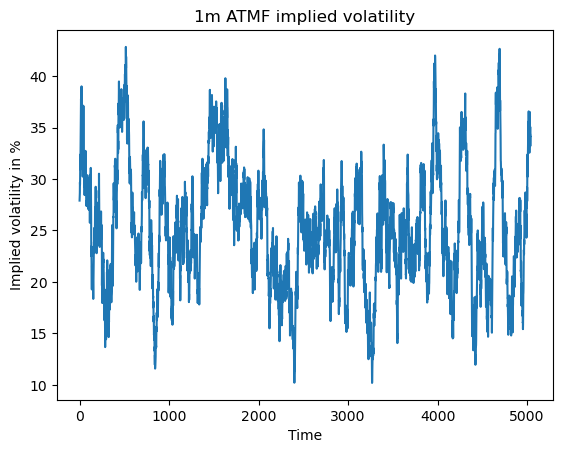

In [3]:
plt.plot(imp_vol_1m)
plt.title('1m ATMF implied volatility')
plt.ylabel('Implied volatility in %')
plt.xlabel('Time')
plt.show()

In [4]:
# Compute percentiles and indices
imp_vol_25pct = np.percentile(imp_vol_1m, 25)
low_vol_indices = imp_vol_1m <= imp_vol_25pct
imp_vol_75pct = np.percentile(imp_vol_1m, 75)
mid_vol_indices = (imp_vol_1m < imp_vol_25pct) ^ (imp_vol_1m <= imp_vol_75pct)
high_vol_indices = imp_vol_1m > imp_vol_75pct

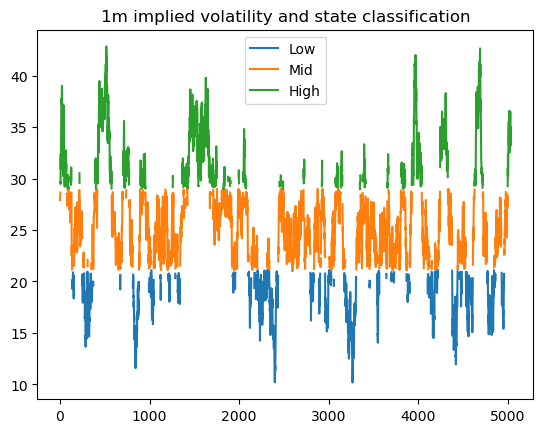

In [5]:
# Plot the 1m implied vol with state classification
vol_low = np.ma.masked_where(low_vol_indices == False, imp_vol_1m)
vol_mid = np.ma.masked_where(mid_vol_indices == False, imp_vol_1m)
vol_high = np.ma.masked_where(high_vol_indices == False, imp_vol_1m)
x = np.arange(0, len(imp_vol_1m))
plt.plot(x, vol_low, x, vol_mid, x, vol_high)
plt.legend(['Low', 'Mid', 'High'])
plt.title('1m implied volatility and state classification')
plt.show()

# Compute scenario probabilities for Fully Flexible Resampling

In [6]:
# Exponential decay prior
T_tilde = len(st_df)
p_exp = ft.exp_decay_probs(st_df, half_life=T_tilde / 2)

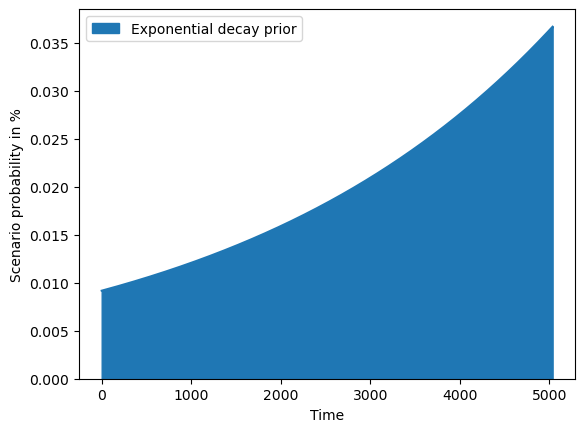

In [7]:
pd.DataFrame(100 * p_exp, columns=['Exponential decay prior']).plot(kind='area')
plt.ylabel('Scenario probability in %')
plt.xlabel('Time')
plt.show()

In [8]:
# Compute view values for Entropy Pooling views
mu_low = np.mean(imp_vol_1m[low_vol_indices])
sigma_low = np.std(imp_vol_1m[low_vol_indices])
mu_mid = np.mean(imp_vol_1m[mid_vol_indices])
sigma_mid = np.std(imp_vol_1m[mid_vol_indices])
mu_high = np.mean(imp_vol_1m[high_vol_indices])
sigma_high = np.std(imp_vol_1m[high_vol_indices])

In [9]:
# Specify left hand sides for Entropy Pooling views
A = np.vstack((np.ones((1, T_tilde)), imp_vol_1m))  # probabilities sum to 1 and mean
b_low = np.array(([[1.], [mu_low]]))
b_mid = np.array(([[1.], [mu_mid]]))
b_high = np.array(([[1.], [mu_high]]))
G = imp_vol_1m[:, np.newaxis].T ** 2
h_low = np.array([[sigma_low ** 2 + mu_low ** 2]])
h_mid = np.array([[sigma_mid ** 2 + mu_mid ** 2]])
h_high = np.array([[sigma_high ** 2 + mu_high ** 2]])

In [10]:
# Compute  Fully Flexible Resampling probability vectors
q_low = ft.entropy_pooling(p_exp, A, b_low, G, h_low)
q_mid = ft.entropy_pooling(p_exp, A, b_mid, G, h_mid)
q_high = ft.entropy_pooling(p_exp, A, b_high, G, h_high)

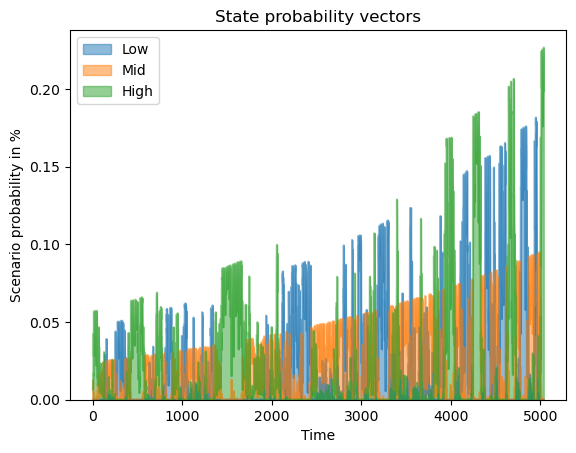

In [11]:
states_prob = np.hstack((q_low / np.sum(q_low), q_mid / np.sum(q_mid), q_high / np.sum(q_high)))
pd.DataFrame(100 * states_prob, columns=['Low', 'Mid', 'High']).plot(kind='area', stacked=False)
plt.title('State probability vectors')
plt.xlabel('Time')
plt.ylabel('Scenario probability in %')
plt.show()

# Simulate

In [12]:
states_vector = 0 * low_vol_indices + 1 * mid_vol_indices + 2 * high_vol_indices

In [13]:
# Define a Fully Flexible Resampling Resampling function
def resampling(S, H, initial_state, states_prob, states_vector):
    sim = np.full((S, H), 1)
    t = np.arange(len(states_vector))
    for s in range(S):
        current_state = initial_state
        for h in range(H):
            sim[s, h] = np.random.choice(t, p=states_prob[:, current_state])
            current_state = states_vector[sim[s, h]]
    return sim

In [14]:
# Simulate historical observations
S = 10000
H = 21
np.random.seed(0)
sim0 = resampling(S, H, 0, states_prob, states_vector)
sim1 = resampling(S, H, 1, states_prob, states_vector)
sim2 = resampling(S, H, 2, states_prob, states_vector)

In [15]:
# Extract equity stationary transformations and compute returns
equity_low = np.full((S, H), np.nan)
equity_mid = np.full((S, H), np.nan)
equity_high = np.full((S, H), np.nan)

for s in range(S):
    equity_low[s, :] = st_df.values[sim0[s, :], 0]
    equity_mid[s, :] = st_df.values[sim1[s, :], 0]
    equity_high[s, :] = st_df.values[sim2[s, :], 0]

return_low = np.exp(np.cumsum(equity_low, axis=1)) - 1
return_mid = np.exp(np.cumsum(equity_mid, axis=1)) - 1
return_high = np.exp(np.cumsum(equity_high, axis=1)) - 1

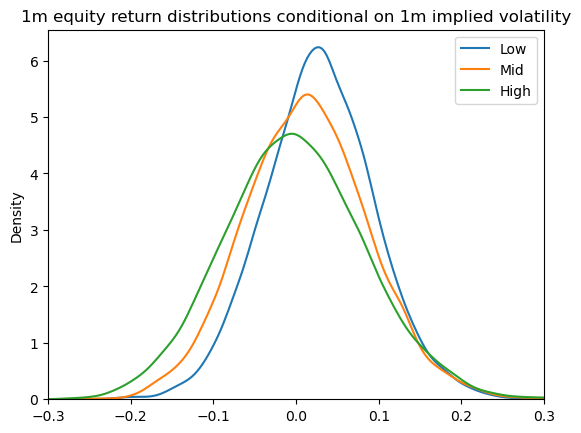

In [16]:
sns.kdeplot(return_low[:, -1])
sns.kdeplot(return_mid[:, -1])
sns.kdeplot(return_high[:, -1])
plt.legend(['Low', 'Mid', 'High'])
plt.title('1m equity return distributions conditional on 1m implied volatility')
plt.xlim([-0.3, 0.3])
plt.show()

# Compute state probability transition matrix

In [17]:
num_states = states_prob.shape[1]
transition_matrix = np.full((num_states, num_states), np.nan)
states = np.unique(states_vector)

for row_state in states:
    for col_state in states:
        transition_matrix[row_state, col_state] = np.sum(states_prob[states_vector == col_state, row_state])

In [18]:
# Print results
np.round(transition_matrix, 3)

array([[0.902, 0.098, 0.   ],
       [0.043, 0.923, 0.035],
       [0.   , 0.11 , 0.89 ]])

In [ ]:
# pcrm-book - Next generation investment analysis.
# Copyright (C) 2025 Anton Vorobets.

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.